In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import numpy as np
import pathlib
import seaborn as sns
from datetime import datetime
import pymannkendall as mk

tqdm_notebook.pandas()

## Read and visualise original data

In [2]:
# Fixed constant
COMPUTE_IDX = (3, 8, 10, 13)
STORAGE_IDX = (1, 2, 5, 11, 12, 15)
NETWORK_IDX = (4, 6, 7, 14)
TOTAL_USER = 250

# Adjustable constant
METRIC_COVERAGE_THRESHOLD = 0.6
SMOOTHEN_WINDOW_SIZE = 5

In [3]:
data1 = pd.read_csv("data1.csv")

In [4]:
# turn time column into time object
data1['ds'] = data1['ds'].map(lambda x: datetime.strptime(x, "%Y/%m/%d"))

In [5]:
print(data1.shape)
print(data1.dtypes)
data1.head()

(807160, 7)
user_id              object
metrics              object
unit                 object
ds           datetime64[ns]
value_avg           float64
value_max           float64
value_min           float64
dtype: object


,user_id,metrics,unit,ds,value_avg,value_max,value_min
0,User 9,"1,1,1",not %,2021-08-14,1.212167,1.872,1.136
1,User 9,"1,1,1",not %,2021-08-17,1.183806,1.848,1.104
2,User 9,"1,1,1",not %,2021-08-20,2.983972,149.912,1.096
3,User 9,"1,1,1",not %,2021-08-23,1.897885,2.376,0.248
4,User 9,"1,1,1",not %,2021-08-26,1.963111,13.080,0.256


In [6]:
# Total number of unique discrete value in some columns
print(f"There are a total of {data1['metrics'].nunique()} unique metrics")
print(f"There are a total of {data1['user_id'].nunique()} unique users")

There are a total of 135 unique metrics
There are a total of 250 unique users


Observation
- Sampling frequency around 3 days
- Value for the same metrics fluctuate a lot (big coorps and small coorps)
- Calculate metric coverage

In [7]:
# Calculate metric coverage
metric_coverage = data1.groupby('metrics')['user_id'].nunique().sort_values(ascending=False)
print(metric_coverage.shape)
metric_coverage.head()

(135,)


metrics
13,1,9    250
4,2,5     247
4,2,3     247
4,2,2     247
4,2,1     247
Name: user_id, dtype: int64

In [8]:
actual_cov_threshold = int(TOTAL_USER * METRIC_COVERAGE_THRESHOLD)
metric_exceed = metric_coverage[metric_coverage >= actual_cov_threshold].size

print(f"{metric_exceed} metrics cover more than {METRIC_COVERAGE_THRESHOLD * 100:.2f}% users")

26 metrics cover more than 60.00% users


## Clean and preprocess data

In [9]:
# Select metric labels with metric coverage >= threshold
selected_metrics = metric_coverage[metric_coverage >= actual_cov_threshold].index.tolist()
selected_metrics

['13,1,9',
 '4,2,5',
 '4,2,3',
 '4,2,2',
 '4,2,1',
 '4,1,5',
 '4,1,4',
 '4,1,3',
 '4,1,2',
 '4,1,1',
 '4,2,4',
 '13,1,4',
 '13,1,7',
 '13,1,6',
 '1,1,1',
 '13,1,11',
 '1,1,4',
 '1,1,2',
 '1,1,3',
 '13,1,8',
 '10,1,7',
 '10,1,2',
 '10,1,12',
 '10,1,11',
 '10,1,18',
 '10,1,9']

In [10]:
# Select data that has the metrics
def preprocess_1(data):
    return data[data['metrics'].isin(selected_metrics)]

In [11]:
data1_pre_1 = preprocess_1(data1)
print(data1_pre_1.shape)
print(f"We have reduced {data1.shape[0] - data1_pre_1.shape[0]} rows")
data1_pre_1.head()

(519117, 7)
We have reduced 288043 rows


,user_id,metrics,unit,ds,value_avg,value_max,value_min
0,User 9,"1,1,1",not %,2021-08-14,1.212167,1.872,1.136
1,User 9,"1,1,1",not %,2021-08-17,1.183806,1.848,1.104
2,User 9,"1,1,1",not %,2021-08-20,2.983972,149.912,1.096
3,User 9,"1,1,1",not %,2021-08-23,1.897885,2.376,0.248
4,User 9,"1,1,1",not %,2021-08-26,1.963111,13.080,0.256


## Data normalisation

In [12]:
data1_pre_2 = data1_pre_1.copy()

# Get min max value in multiple group keys
agg_cols = {
    'value_avg': ['min', 'max'],
}
agg_res_pre_2 = data1_pre_2.groupby(['user_id', 'metrics']).agg(agg_cols)
agg_res_pre_2.head()

value_avg              
                           min           max
user_id   metrics                           
User 1006 1,1,1       0.475493  3.777971e+02
          1,1,2       0.000000  5.290021e+03
          1,1,3    3617.084701  6.984103e+07
          1,1,4       0.000000  1.135951e+08
          10,1,11     0.798572  9.971386e+02

In [13]:
# Example of how to access multi index dataframe
agg_res_pre_2["value_avg", "max"]["User 1006", "1,1,1"]

377.79713819999995

In [14]:
# Normalise each data to 0-1
def normalise_row(row, agg_res, for_col):
    val_max = agg_res[for_col, "max"][row["user_id"], row["metrics"]]
    val_min = agg_res[for_col, "min"][row["user_id"], row["metrics"]]
    min_max_diff = val_max - val_min
    if min_max_diff < 1e-8:
        return 0
    return (row[for_col] - val_min) / (val_max - val_min)

def preprocess_2(data):
    # Get min max from avg column
    process_data = data.copy()
    agg_criteria = {
        'value_avg': ['min', 'max'],
        'value_max': ['min', 'max'],
        'value_min': ['min', 'max']
    }
    agg_res = process_data.groupby(['user_id', 'metrics']).agg(agg_criteria)

    # Drop null max/min (cannot normalise), unused cols and add new normalised column
    process_data['value_avg_normalised'] = process_data.progress_apply(lambda r: normalise_row(r, agg_res, "value_avg"), axis=1)
    # process_data['value_max_normalised'] = process_data.progress_apply(lambda r: normalise_row(r, agg_res, "value_max"), axis=1)
    # process_data['value_min_normalised'] = process_data.progress_apply(lambda r: normalise_row(r, agg_res, "value_min"), axis=1)
    process_data = process_data.drop(columns=['value_min', 'value_max', 'value_avg', 'unit'])

    return process_data

data1_pre_2 = preprocess_2(data1_pre_1)
data1_pre_2.to_csv('pre_process_1.csv')
print(data1_pre_2.shape)
data1_pre_2.head(20)

  0%|          | 0/519117 [00:00<?, ?it/s]

(519117, 4)


,user_id,metrics,ds,value_avg_normalised
0,User 9,"1,1,1",2021-08-14,0.000493
1,User 9,"1,1,1",2021-08-17,0.000000
2,User 9,"1,1,1",2021-08-20,0.031275
3,User 9,"1,1,1",2021-08-23,0.012406
4,User 9,"1,1,1",2021-08-26,0.013539
5,User 9,"1,1,1",2021-08-29,0.012421
6,User 9,"1,1,1",2021-09-01,0.014119
7,User 9,"1,1,1",2021-09-04,0.012757
8,User 9,"1,1,1",2021-09-07,0.013370
9,User 9,"1,1,1",2021-09-10,0.012995


## Visualise new data

In [15]:
# Check unique user
data1_pre_2['user_id'].unique()

array(['User 9', 'User 24', 'User 28', 'User 33', 'User 34', 'User 43',
       'User 61', 'User 66', 'User 72', 'User 75', 'User 76', 'User 92',
       'User 98', 'User 105', 'User 114', 'User 124', 'User 128',
       'User 144', 'User 151', 'User 154', 'User 157', 'User 162',
       'User 177', 'User 181', 'User 183', 'User 191', 'User 206',
       'User 213', 'User 215', 'User 224', 'User 226', 'User 233',
       'User 242', 'User 246', 'User 249', 'User 252', 'User 261',
       'User 274', 'User 278', 'User 283', 'User 295', 'User 297',
       'User 299', 'User 302', 'User 305', 'User 319', 'User 320',
       'User 330', 'User 332', 'User 335', 'User 337', 'User 347',
       'User 356', 'User 360', 'User 362', 'User 371', 'User 382',
       'User 400', 'User 405', 'User 417', 'User 429', 'User 449',
       'User 452', 'User 454', 'User 455', 'User 472', 'User 473',
       'User 481', 'User 483', 'User 486', 'User 487', 'User 488',
       'User 489', 'User 492', 'User 499', 'User 508

In [16]:
# function to generate data_pair to visualise
def get_pair_data(users, metrics, data):
    data_pairs = [] # [(metric_string, df), ...]

    for metric in metrics:
        visualise_data = data[data['user_id'].isin(users)]
        visualise_data = visualise_data[visualise_data['metrics'].isin([metric])]
        # visualise_data['value_min_normalised_smooth'] = visualise_data['value_min_normalised'].rolling(SMOOTHEN_WINDOW_SIZE).mean()
        # visualise_data['value_max_normalised_smooth'] = visualise_data['value_max_normalised'].rolling(SMOOTHEN_WINDOW_SIZE).mean()
        visualise_data['value_avg_normalised_smooth'] = visualise_data['value_avg_normalised'].rolling(SMOOTHEN_WINDOW_SIZE).mean()
        data_pairs.append((metric, visualise_data))

    return data_pairs

In [17]:
# Select some user data and specific metrics to visualise
selected_user_to_visualise = ['User 283', 'User 181', 'User 183']
selected_metrics = ['1,1,1', '10,1,2']

# generate data
vis_data_pairs = get_pair_data(selected_user_to_visualise, selected_metrics, data1_pre_2)
for (metric, vis_data) in vis_data_pairs:
    print(f"{metric}: {vis_data.shape}")

1,1,1: (282, 5)
10,1,2: (193, 5)


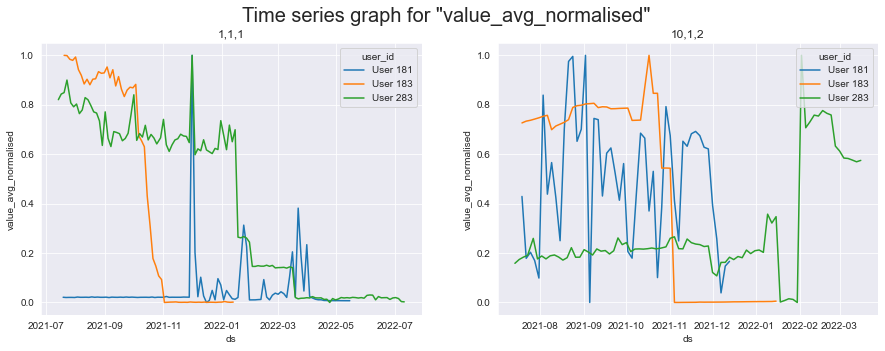

In [18]:
# Plot the graph
def plot_trend(data_pair, draw_for):
    fig, axes = plt.subplots(1, len(selected_metrics), figsize=(15, 5))
    fig.suptitle(f'Time series graph for "{draw_for}"', fontsize=20)
    for idx, (metric, vis_data) in enumerate(data_pair):
        sns.lineplot(ax=axes[idx], data=vis_data, x='ds', y=draw_for, hue='user_id')
        axes[idx].set_title(metric)

plot_trend(vis_data_pairs, "value_avg_normalised")
# plot_trend(vis_data_pairs, "value_min_normalised")
# plot_trend(vis_data_pairs, "value_max_normalised")

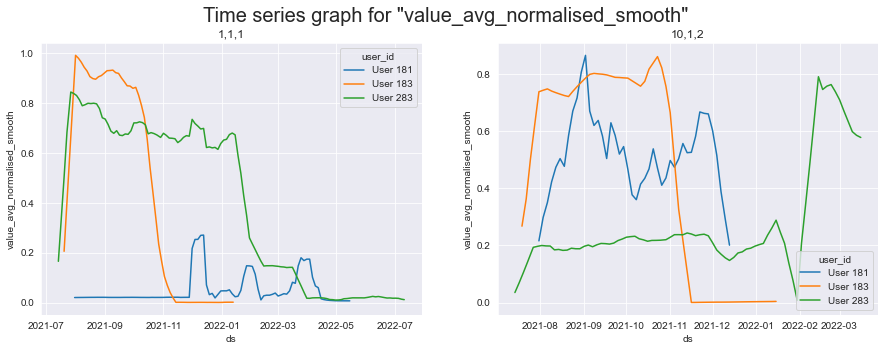

In [19]:
# Smoothen time series data
plot_trend(vis_data_pairs, "value_avg_normalised_smooth")
# plot_trend(vis_data_pairs, "value_min_normalised_smooth")
# plot_trend(vis_data_pairs, "value_max_normalised_smooth")

In [21]:
# Trend test
trend_test_res = {
    'increasing': 0,
    'decreasing': 0,
    'no trend': 0,
}
none_decreasing_trend = []

# select some user and all metrics to do trend test
selected_user_to_visualise = data1_pre_2['user_id'].unique().tolist()
selected_metrics = metric_coverage[metric_coverage >= actual_cov_threshold].index.tolist()
trend_data_pairs = get_pair_data(selected_user_to_visualise, selected_metrics, data1_pre_2)

# Loop over each metric and calculate trend
for (metric, vis_data) in trend_data_pairs:
    smooth_norm_data = vis_data.sort_values('ds')['value_avg_normalised_smooth'].tolist()
    mk_res = mk.original_test(smooth_norm_data)
    if mk_res[0] != 'decreasing':
        print(f"{metric} = {mk_res[0]}")
        none_decreasing_trend.append(metric)

    trend_test_res[mk_res[0]] = trend_test_res[mk_res[0]] + 1

percentage_decreasing_trend = trend_test_res['decreasing'] / (trend_test_res['decreasing'] + trend_test_res['increasing'] + trend_test_res['no trend'])
print(f"\n{percentage_decreasing_trend * 100:.2f}% of selected metrics has decreasing trend")

10,1,2 = increasing

96.15% of selected metrics has decreasing trend


In [22]:
# remove non-decreasing trend
def preprocess_3(data):
    return data[~data['metrics'].isin(none_decreasing_trend)]

data1_pre_3 = preprocess_3(data1_pre_2)
print(data1_pre_3.shape)
print(f"We have reduced {data1_pre_2.shape[0] - data1_pre_3.shape[0]} rows")
data1_pre_3.head()

(508911, 4)
We have reduced 10206 rows


,user_id,metrics,ds,value_avg_normalised
0,User 9,"1,1,1",2021-08-14,0.000493
1,User 9,"1,1,1",2021-08-17,0.000000
2,User 9,"1,1,1",2021-08-20,0.031275
3,User 9,"1,1,1",2021-08-23,0.012406
4,User 9,"1,1,1",2021-08-26,0.013539


## Feature selection based on normal user

In [23]:
# Normal user data
data3 = pd.read_csv("data3.csv")
data3['ds'] = data3['ds'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
data3.shape

(905785, 7)

In [24]:
# Preprocess
data3_pre_3 = preprocess_3(preprocess_2(preprocess_1(data3)))

  0%|          | 0/497382 [00:00<?, ?it/s]

In [25]:
data3_pre_3['user_id'].unique()

array(['User 201', 'User 202', 'User 203', 'User 204', 'User 205',
       'User 207', 'User 208', 'User 209', 'User 210', 'User 211',
       'User 212', 'User 214', 'User 216', 'User 217', 'User 218',
       'User 219', 'User 220', 'User 221', 'User 222', 'User 223',
       'User 225', 'User 227', 'User 228', 'User 229', 'User 230',
       'User 231', 'User 232', 'User 234', 'User 235', 'User 236',
       'User 237', 'User 238', 'User 239', 'User 240', 'User 241',
       'User 243', 'User 244', 'User 245', 'User 247', 'User 248',
       'User 250', 'User 251', 'User 253', 'User 254', 'User 255',
       'User 256', 'User 257', 'User 258', 'User 259', 'User 260',
       'User 262', 'User 263', 'User 264', 'User 265', 'User 266',
       'User 267', 'User 268', 'User 269', 'User 270', 'User 271',
       'User 272', 'User 273', 'User 275', 'User 276', 'User 277',
       'User 279', 'User 280', 'User 281', 'User 282', 'User 284',
       'User 285', 'User 286', 'User 287', 'User 288', 'User 2

In [26]:
# Trend test for normal user
trend_test_res = {
    'increasing': 0,
    'decreasing': 0,
    'no trend': 0,
}
decreasing_trend = []

# select some user and all metrics to do trend test
selected_user_to_visualise = data3_pre_3['user_id'].unique().tolist()
selected_metrics = data3_pre_3['metrics'].unique().tolist()
trend_data_pairs = get_pair_data(selected_user_to_visualise, selected_metrics, data3_pre_3)

# Loop over each metric and calculate trend
for (metric, vis_data) in trend_data_pairs:
    smooth_norm_data = vis_data.sort_values('ds')['value_avg_normalised_smooth'].tolist()
    mk_res = mk.original_test(smooth_norm_data)
    # print(mk_res)
    if mk_res[0] == 'decreasing':
        print(f"{metric} = {mk_res[0]}")
        decreasing_trend.append(metric)

    trend_test_res[mk_res[0]] = trend_test_res[mk_res[0]] + 1

percentage_decreasing_trend = trend_test_res['decreasing'] / (trend_test_res['decreasing'] + trend_test_res['increasing'] + trend_test_res['no trend'])
print(f"\n{percentage_decreasing_trend * 100:.2f}% of selected metrics has decreasing trend")


0.00% of selected metrics has decreasing trend


In [27]:
# remove decreasing trend corresponding to normal users
def preprocess_4(data):
    return data[~data['metrics'].isin(decreasing_trend)]

In [28]:
data3_pre_4 = preprocess_4(data3_pre_3)
data1_pre_4 = preprocess_4(data1_pre_3)
print(f"Dimension for data1 {data1_pre_4.shape}")
print(f"Dimension for data3 {data3_pre_4.shape}")

Dimension for data1 (508911, 4)
Dimension for data3 (482509, 4)


In [29]:
print(f"After 4 round of preprocessing, we have {data1_pre_4['metrics'].nunique()} metrics")

After 4 round of preprocessing, we have 25 metrics


## Convert time series to a value

In [30]:
def get_trend_score(value_avg_normalised, ):
    total_val = len(value_avg_normalised)
    if total_val == 1:
        return 0
    sum_diff = (value_avg_normalised - value_avg_normalised.shift(1)).sum()
    trend_score = sum_diff / (total_val - 1)
    return trend_score

def preprocess_5(data):
    process_data = {
        'user_id': [],
        'metrics': [],
        'trend_score': [],
    }

    # Loop over each group to calculate trend based on n last dates
    for name, group in tqdm_notebook(data.groupby(['user_id', 'metrics'])):
        last_rows = group.sort_values(by=["ds"]).tail(10)
        trend_score = get_trend_score(last_rows['value_avg_normalised'])
        # print(last_rows)
        process_data['user_id'].append(name[0])
        process_data['metrics'].append(name[1])
        process_data['trend_score'].append(trend_score)
        # break

    return pd.DataFrame(process_data)

data1_pre_5 = preprocess_5(data1_pre_4)
data1_pre_5

  0%|          | 0/5665 [00:00<?, ?it/s]

,user_id,metrics,trend_score
0,User 1006,"1,1,1",-8.338745e-04
1,User 1006,"1,1,2",-2.864700e-07
2,User 1006,"1,1,3",-5.071601e-05
3,User 1006,"1,1,4",-5.540885e-07
4,User 1006,"10,1,11",8.293694e-04
...,...,...,...
5660,User 994,"4,2,1",-2.821087e-02
5661,User 994,"4,2,2",-6.158711e-03
5662,User 994,"4,2,3",-6.158711e-03
5663,User 994,"4,2,4",-2.821087e-02


## Preprocess other files based on our selected metrics

In [31]:
# Add metric type to column
def add_metric_type(row):
    metric_type = int(row['metrics'].split(",", 1)[0])
    if metric_type in COMPUTE_IDX:
        return "COMPUTE"
    if metric_type in STORAGE_IDX:
        return "STORAGE"
    if metric_type in NETWORK_IDX:
        return "NETWORK"
    raise ValueError(f"Cannot find corresponding index type for index '{metric_type}'")

def preprocess_6(data):
    process_data = data.copy()
    new_col = process_data.progress_apply(lambda r: add_metric_type(r), axis=1)
    process_data['metrics_type'] = new_col
    return process_data

In [32]:
data4 = pd.read_csv("data4.csv")
data4['ds'] = data4['ds'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [33]:
# Combine everything together
data_to_process = {
    "data1": data1,
    "data3": data3,
    "data4": data4,
}
preprocess_chain = [preprocess_1, preprocess_2, preprocess_3, preprocess_4, preprocess_5, preprocess_6]

for data_name, data_obj in data_to_process.items():
    preprocess_data = data_obj
    print(f"Processing: {data_name}.csv....")
    for preprocess_func in preprocess_chain:
        preprocess_data = preprocess_func(preprocess_data)
    preprocess_data.to_csv(f"preprocessed_{data_name}.csv", index=False)

Processing: data1.csv....


  0%|          | 0/508911 [00:00<?, ?it/s]

  0%|          | 0/5665 [00:00<?, ?it/s]

  0%|          | 0/5665 [00:00<?, ?it/s]

Processing: data3.csv....


  0%|          | 0/482509 [00:00<?, ?it/s]

  0%|          | 0/4362 [00:00<?, ?it/s]

  0%|          | 0/4362 [00:00<?, ?it/s]

Processing: data4.csv....


  0%|          | 0/505879 [00:00<?, ?it/s]

  0%|          | 0/4704 [00:00<?, ?it/s]

  0%|          | 0/4704 [00:00<?, ?it/s]